# PID Delay Map
Author: Petr Zahradník <zahrape9@fel.cvut.cz>

## Python setup

In [ ]:
%pip install osmnx numpy

Python interpreter will be restarted.
  Using cached osmnx-1.3.0-py3-none-any.whl (93 kB)
  Using cached numpy-1.24.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached geopandas-0.12.2-py3-none-any.whl (1.1 MB)
  Using cached networkx-3.0-py3-none-any.whl (2.0 MB)
  Using cached pandas-1.5.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached matplotlib-3.6.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
  Using cached shapely-2.0.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached pyproj-3.4.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.7 MB)
  Using cached Fiona-1.8.22-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.6 MB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10

In [ ]:
import matplotlib.pyplot as plt
import osmnx as ox

custom_filter='["highway"~"motorway|motorway_link|trunk|trunk_link|primary|primary_link|secondary|secondary_link|road|road_link"]'
prague_graph = ox.graph_from_place("Středočeský kraj, Czechia", custom_filter=custom_filter)


/databricks/python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Stream Setup

In [ ]:
from pyspark.sql.types import *

schema_pid = StructType(
    [
        StructField(
            "geometry",
            StructType(
                [
                    StructField("coordinates", ArrayType(StringType()), True),
                    StructField("type", StringType()),
                ]
            ),
        ),
        StructField(
            "properties",
            StructType(
                [
                    StructField(
                        "last_position",
                        StructType(
                            [
                                StructField("bearing", IntegerType()),
                                StructField(
                                    "delay",
                                    StructType(
                                        [
                                            StructField("actual", IntegerType()),
                                            StructField(
                                                "last_stop_arrival", StringType()
                                            ),
                                            StructField(
                                                "last_stop_departure", StringType()
                                            ),
                                        ]
                                    ),
                                ),
                                StructField("is_canceled", BooleanType()),
                                StructField(
                                    "last_stop",
                                    StructType(
                                        [
                                            StructField("arrival_time", StringType()),
                                            StructField("departure_time", StringType()),
                                            StructField("id", StringType()),
                                            StructField("sequence", IntegerType()),
                                        ]
                                    ),
                                ),
                                StructField(
                                    "next_stop",
                                    StructType(
                                        [
                                            StructField("arrival_time", StringType()),
                                            StructField("departure_time", StringType()),
                                            StructField("id", StringType()),
                                            StructField("sequence", IntegerType()),
                                        ]
                                    ),
                                ),
                                StructField("origin_timestamp", StringType()),
                                StructField("shape_dist_traveled", StringType()),
                                StructField("speed", StringType()),
                                StructField("state_position", StringType()),
                                StructField("tracking", BooleanType()),
                            ]
                        ),
                    ),
                    StructField(
                        "trip",
                        StructType(
                            [
                                StructField(
                                    "agency_name",
                                    StructType(
                                        [
                                            StructField("real", StringType()),
                                            StructField("scheduled", StringType()),
                                        ]
                                    ),
                                ),
                                StructField(
                                    "cis",
                                    StructType(
                                        [
                                            StructField("line_id", StringType()),
                                            StructField("trip_number", StringType()),
                                        ]
                                    ),
                                ),
                                StructField(
                                    "gtfs",
                                    StructType(
                                        [
                                            StructField("route_id", StringType()),
                                            StructField(
                                                "route_short_name", StringType()
                                            ),
                                            StructField("route_type", IntegerType()),
                                            StructField("trip_headsign", StringType()),
                                            StructField("trip_id", StringType()),
                                            StructField(
                                                "trip_short_name", StringType()
                                            ),
                                        ]
                                    ),
                                ),
                                StructField("origin_route_name", StringType()),
                                StructField("sequence_id", IntegerType()),
                                StructField("start_timestamp", StringType()),
                                StructField(
                                    "vehicle_registration_number", IntegerType()
                                ),
                                StructField(
                                    "vehicle_type",
                                    StructType(
                                        [
                                            StructField("description_cs", StringType()),
                                            StructField("description_en", StringType()),
                                            StructField("id", IntegerType()),
                                        ]
                                    ),
                                ),
                                StructField("wheelchair_accessible", BooleanType()),
                                StructField("air_conditioned", BooleanType()),
                            ]
                        ),
                    ),
                ]
            ),
        ),
        StructField("type", StringType()),
    ]
)

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import from_json, col

# connect to broker
JAAS = 'org.apache.kafka.common.security.scram.ScramLoginModule required username="fel.student" password="FelBigDataWinter2022bflmpsvz";'
df_regbuses = spark.readStream \
  .format("kafka")\
  .option("kafka.bootstrap.servers", "CENSORED") \
  .option("kafka.sasl.mechanism", "SCRAM-SHA-512")\
  .option("kafka.security.protocol", "SASL_SSL") \
  .option("kafka.sasl.jaas.config", JAAS) \
  .option("subscribe", "regbuses") \
  .load()

select_base_regbuses = df_regbuses.select(from_json(col("value").cast("string"),schema_pid).alias("data")).select("data.*") \
regbuses_stream = select_base_regbuses.writeStream \
        .option("checkpointLocation", "checkpoints/regbuses")\
        .toTable("regbuses", outputMode="append")

## Data preparation
We only consider routes starting or ending in Prague. This is achieved by filtering headsign on the pattern `%Praha%`.

In [ ]:
%sql
SELECT COUNT(*) FROM regbuses

count(1)
201772


Output can only be rendered in Databricks

In [ ]:
%sql
DROP TABLE IF EXISTS routes;
CREATE TABLE routes
SELECT DISTINCT properties.trip.gtfs.route_id AS route_id
FROM regbuses
WHERE properties.trip.gtfs.trip_headsign LIKE '%Praha%';
SELECT COUNT(*) FROM routes;

count(1)
92


Output can only be rendered in Databricks

In [ ]:
%sql
DROP TABLE IF EXISTS regbuses_delay;
CREATE TABLE regbuses_delay AS
SELECT
  coordinates AS last_coordinates,
  delay AS last_delay,
  route_id,
  trip_id,
  origin_timestamp,
  to_prague
FROM
  (
    SELECT
      geometry.coordinates AS coordinates,
      properties.last_position.delay.actual AS delay,
      properties.trip.gtfs.route_id AS route_id,
      properties.trip.gtfs.trip_id AS trip_id,
      properties.last_position.origin_timestamp AS origin_timestamp,
      properties.trip.gtfs.trip_headsign LIKE 'Praha%' AS to_prague,
      row_number() OVER (
        PARTITION BY properties.trip.gtfs.trip_id
        ORDER BY
          properties.last_position.origin_timestamp DESC
      ) AS rn
    FROM
      regbuses b
      INNER JOIN routes r ON b.properties.trip.gtfs.route_id = r.route_id
  )
WHERE rn = 1;
SELECT to_prague, COUNT(*) FROM regbuses_delay GROUP BY to_prague;

to_prague,count(1)
true,1288
false,1274


Output can only be rendered in Databricks

Out[7]: Text(0.5, 1.0, 'Unique trips by time')

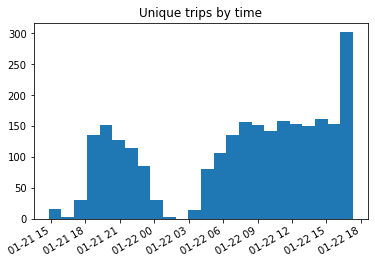

In [ ]:
df_trips_by_hour = spark.sql("SELECT origin_timestamp::timestamp FROM regbuses_delay").toPandas()

plt.hist(df_trips_by_hour.loc[:,'origin_timestamp'], bins=24)
plt.gcf().autofmt_xdate()
plt.title('Unique trips by time')

## Actual delay

First, we plot the actual delay of all buses en route. For each bus trip within last 30 minutes we collect the last position and delay.

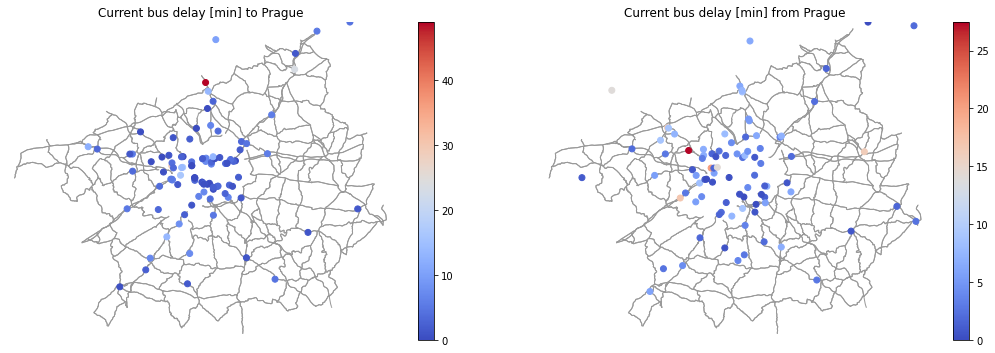

In [ ]:
import matplotlib.pyplot as plt

df_regbuses_to = spark.sql("SELECT last_coordinates[0]::float AS longitude, last_coordinates[1]::float AS latitude, last_delay FROM regbuses_delay WHERE to_prague AND origin_timestamp > now() - '30 minutes'::interval").toPandas()
df_regbuses_from = spark.sql("SELECT last_coordinates[0]::float AS longitude, last_coordinates[1]::float AS latitude, last_delay FROM regbuses_delay WHERE NOT to_prague AND origin_timestamp > now() - '30 minutes'::interval").toPandas()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.tight_layout()
ox.plot_graph(prague_graph, ax=axes[0], show=False, close=False, edge_color="#999999", bgcolor="#ffffff", node_size=0)
sc_to = axes[0].scatter(df_regbuses_to.loc[:,'longitude'], df_regbuses_to.loc[:,'latitude'], c=df_regbuses_to.loc[:,'last_delay'] / 60, vmin=0, cmap="coolwarm")
plt.colorbar(sc_to)
axes[0].title.set_text("Current bus delay [min] to Prague")
ox.plot_graph(prague_graph, ax=axes[1], show=False, close=False, edge_color="#999999", bgcolor="#ffffff", node_size=0)
sc_from = axes[1].scatter(df_regbuses_from.loc[:,'longitude'], df_regbuses_from.loc[:,'latitude'], c=df_regbuses_from.loc[:,'last_delay'] / 60, vmin=0, cmap="coolwarm")
plt.colorbar(sc_from)
axes[1].title.set_text("Current bus delay [min] from Prague")
plt.show()

## Delay difference by line

In [ ]:
%sql
DROP TABLE IF EXISTS routes_avg_delay;
CREATE TABLE routes_avg_delay AS
SELECT
  d.route_id,
  AVG(last_delay) FILTER(WHERE d.to_prague) AS avg_delay_to,
  AVG(last_delay) FILTER(WHERE NOT d.to_prague) AS avg_delay_from
FROM regbuses_delay d
GROUP BY d.route_id
HAVING
  avg_delay_to IS NOT NULL
  AND avg_delay_from IS NOT NULL;
SELECT * FROM routes_avg_delay;

route_id,avg_delay_to,avg_delay_from
L370,216.2,123.2
L304,78.1,36.875
L405,884.25,150.5
L348,335.64516129032256,240.32258064516128
L329,123.5,45.2
L337,102.44444444444444,85.27272727272727
L406,53.642857142857146,142.0
L356,117.0,81.27777777777777
L385,117.66666666666667,69.78125
L345,356.4761904761905,160.45


Out[10]: Text(0.5, 1.0, 'TOP 10 routes delayed more traveling from Prague')

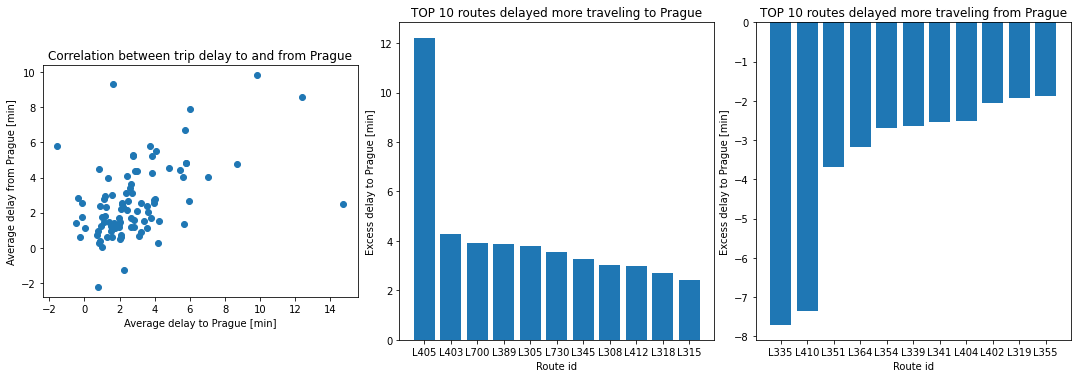

In [ ]:
df_avg_delay = spark.sql("SELECT route_id, avg_delay_to, avg_delay_from FROM routes_avg_delay").toPandas()
df_avg_delay_diff = spark.sql("SELECT route_id, avg_delay_to - avg_delay_from AS diff_to_from FROM routes_avg_delay ORDER BY diff_to_from DESC").toPandas()
df_avg_delay_diff_rev = spark.sql("SELECT route_id, avg_delay_to - avg_delay_from AS diff_to_from FROM routes_avg_delay ORDER BY diff_to_from").toPandas()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.tight_layout()
axes[0].scatter(df_avg_delay.loc[:,'avg_delay_to']/60, df_avg_delay.loc[:,'avg_delay_from']/60)
axes[0].set_xlabel('Average delay to Prague [min]')
axes[0].set_ylabel('Average delay from Prague [min]')
axes[0].set_aspect('equal', 'box')
axes[0].set_title("Correlation between trip delay to and from Prague")
axes[1].bar(df_avg_delay_diff.loc[0:10,'route_id'], df_avg_delay_diff.loc[0:10,'diff_to_from']/60)
axes[1].set_xlabel('Route id')
axes[1].set_ylabel('Excess delay to Prague [min]')
axes[1].set_title("TOP 10 routes delayed more traveling to Prague")
axes[2].bar(df_avg_delay_diff_rev.loc[0:10,'route_id'], df_avg_delay_diff_rev.loc[0:10,'diff_to_from']/60)
axes[2].set_xlabel('Route id')
axes[2].set_ylabel('Excess delay to Prague [min]')
axes[2].set_title("TOP 10 routes delayed more traveling from Prague")

## Delay difference by hour of the day

In [ ]:
%sql
DROP TABLE IF EXISTS hour_avg_delay;
CREATE TABLE hour_avg_delay AS
SELECT
  DATE_PART('hour', d.origin_timestamp) AS hour_of_day,
  AVG(last_delay) FILTER(WHERE d.to_prague) AS avg_delay_to,
  STD(last_delay) FILTER(WHERE d.to_prague) AS std_delay_to,
  AVG(last_delay) FILTER(WHERE NOT d.to_prague) AS avg_delay_from,
  STD(last_delay) FILTER(WHERE NOT d.to_prague) AS std_delay_from
FROM
  regbuses_delay d
  INNER JOIN routes r ON d.route_id = r.route_id
GROUP BY DATE_PART('hour', d.origin_timestamp)
HAVING
  avg_delay_to IS NOT NULL
  AND avg_delay_from IS NOT NULL;
SELECT * FROM hour_avg_delay;

hour_of_day,avg_delay_to,std_delay_to,avg_delay_from,std_delay_from
12,180.84722222222223,188.89371478461908,94.71232876712328,148.92293676895582
22,96.1875,273.3482430309094,102.92307692307692,132.60849736974112
13,301.7,399.22092064201854,155.26470588235293,171.02671674393656
16,344.44,416.57001098741375,242.43835616438355,367.34157531215527
6,57.75757575757576,131.90311836356497,81.01923076923077,150.75983893162928
20,145.4516129032258,197.90399041854968,265.2121212121212,448.69912876949985
5,96.33333333333333,135.07119017427195,86.56410256410257,122.67346362381268
19,161.79661016949152,351.99543392713537,252.88235294117646,346.90019767451827
15,232.79310344827587,283.67231086569683,189.12328767123287,306.1443443688632
9,80.72222222222223,161.70406130607697,57.666666666666664,123.35498211626164


Out[12]: Text(698.9485294117648, 0.5, 'Excess delay to Prague [min]')

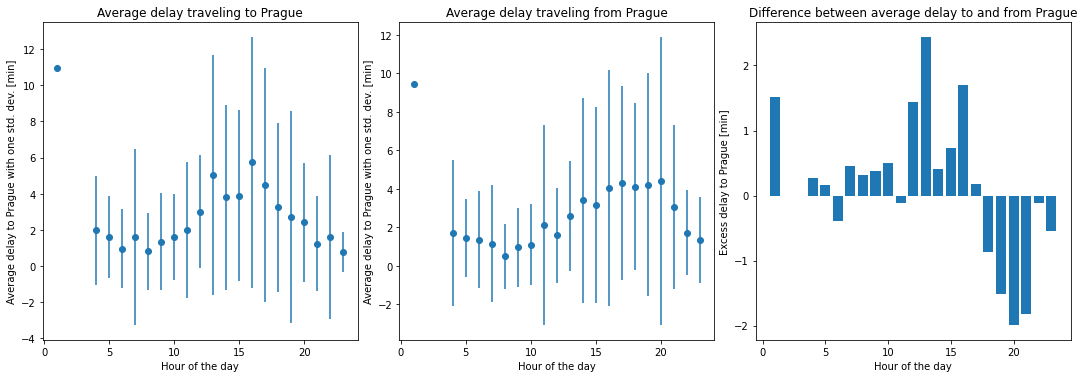

In [ ]:
df_delay_by_hour = spark.sql('SELECT hour_of_day, avg_delay_to, std_delay_to, avg_delay_from, std_delay_from FROM hour_avg_delay').toPandas()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.tight_layout()
axes[0].errorbar(df_delay_by_hour.loc[:,'hour_of_day'], df_delay_by_hour.loc[:,'avg_delay_to']/60, yerr=df_delay_by_hour.loc[:,'std_delay_to']/60, fmt='o')
axes[0].set_title("Average delay traveling to Prague")
axes[0].set_xlabel('Hour of the day')
axes[0].set_ylabel('Average delay to Prague with one std. dev. [min]')
axes[1].errorbar(df_delay_by_hour.loc[:,'hour_of_day'], df_delay_by_hour.loc[:,'avg_delay_from']/60, yerr=df_delay_by_hour.loc[:,'std_delay_from']/60, fmt='o')
axes[1].set_title("Average delay traveling from Prague")
axes[1].set_xlabel('Hour of the day')
axes[1].set_ylabel('Average delay to Prague with one std. dev. [min]')
axes[2].bar(df_delay_by_hour.loc[:,'hour_of_day'], (df_delay_by_hour.loc[:,'avg_delay_to'] - df_delay_by_hour.loc[:,'avg_delay_from'])/60)
axes[2].set_title("Difference between average delay to and from Prague")
axes[2].set_xlabel('Hour of the day')
axes[2].set_ylabel('Excess delay to Prague [min]')